**Tutorial 5 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_05_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

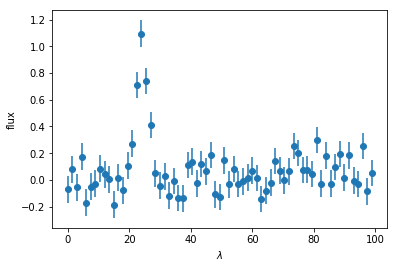

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa
%matplotlib inline

df = pa.read_csv('tut_05_data.csv')
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

2) First we need to subtract off the continuum. We know that there is a line centered around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assuming the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

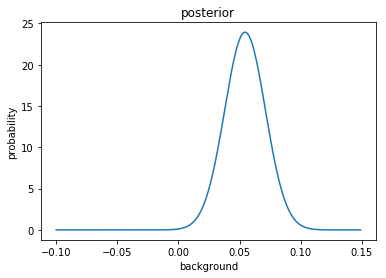

Posterior at edges of parameter space:  5.145873718776107e-18 2.52702008593455e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [0.0545]
The average of posterior  : 0.05453108678141714
The variance of posterior  : 0.016666664987686954


In [2]:

import scipy.optimize as opt

## filter out the background dominated region of the spectrum
f = df['flux'][ df['wavelength'] > 45 ]
l = df['wavelength'][ df['wavelength'] > 45 ]
s = df['sigma'][ df['wavelength'] > 45 ]

#plt.plot(l,f)
#plt.show()

## make a log-likelihood function assuming the noise Gaussian and 
## the pixels are independent
def loglike(b):
    return -0.5*np.sum( ( (f - b)/s )**2  )   ## this is chi^2

## Make an array of possible background values.
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum.
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## calculate the likelihood at each of these background values
likelihood = np.empty(len(background))
for i,b in enumerate(background) :
    likelihood[i] = np.exp( loglike(b) )

## normalize to get the posterior
## You should look at the plot and make sure that
## the sum is a good approximation of the integral.
posterior = likelihood/np.sum(likelihood)/db
    
## plot posterior for background
plt.plot(background,posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')

plt.show()

print('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## find maximum of posterior and the variance
bmax = opt.fmin(lambda x: -loglike(x),0)
print('The maximum likelihood background is :',bmax)
bave = np.sum(posterior*background)*db
variance = np.sum(posterior*(background-bave)**2)*db
print('The average of posterior  :',bave)
print('The variance of posterior  :',np.sqrt(variance))


3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

Write a function for the line profile.  

Write a function that returns the log-likelihood for the data with this model. 

Find the maximum likelihood values for the parameters using the whole data set.  Use the library function scipy.optimize.minimize() to do this.  Read the documentation for this function before starting.  You will need to make a guess to start the minimization.  Make these guesses from the plot of the data.

Draw the best fit model over the data.

In [3]:
f = df['flux']
l = df['wavelength']
s = df['sigma']
def line(ll,A,l0,dl):
    return A*np.exp(-(((ll-l0)/dl)**2))
    
#def loglike(A,lo,dl,b):
def negloglike(p):
    return 0.5*np.sum(((f-line(l,p[0],p[1],p[2])-p[3])/s)**2)


4) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the posterior for $A$ near its maximum likelihood value with uniform and Jeffreys priors on $A$.

The values of the parameters (A, lambda0, delta lambda, b) that maximize the likelihood are: [ 1.0286677  24.11716856  2.61398132  0.0286165 ]


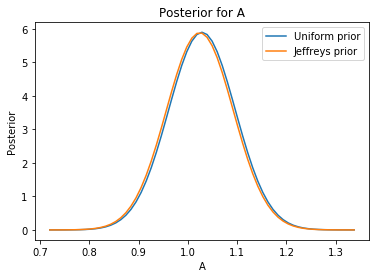

In [4]:
maxlike = opt.minimize(negloglike,[1.2,25.,10.,0.])
#print(maxlike)
print('The values of the parameters (A, lambda0, delta lambda, b) that maximize the likelihood are: ' +str(maxlike.x))
steps = 100.
dA = maxlike.x[0]/steps
A_arr = np.arange(0.7*maxlike.x[0],1.3*maxlike.x[0],dA)

likelihood_A = np.empty(len(A_arr))
likelihood_A_J=np.empty(len(A_arr))
for i in range(len(A_arr)) :
    likelihood_A[i] = np.exp(-negloglike([A_arr[i],maxlike.x[1],maxlike.x[2],maxlike.x[3]]))
    likelihood_A_J[i] = np.exp(-negloglike([A_arr[i],maxlike.x[1],maxlike.x[2],maxlike.x[3]]))/A_arr[i]
posterior_A = likelihood_A/(np.sum(likelihood_A)*dA)
posterior_A_J= likelihood_A_J/(np.sum(likelihood_A_J)*dA)

plt.plot(A_arr,posterior_A,label='Uniform prior')
plt.plot(A_arr,posterior_A_J,label='Jeffreys prior')
plt.title('Posterior for A')
plt.xlabel('A')
plt.ylabel('Posterior')
plt.legend()
plt.show()



5) Make a 2D map of the posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

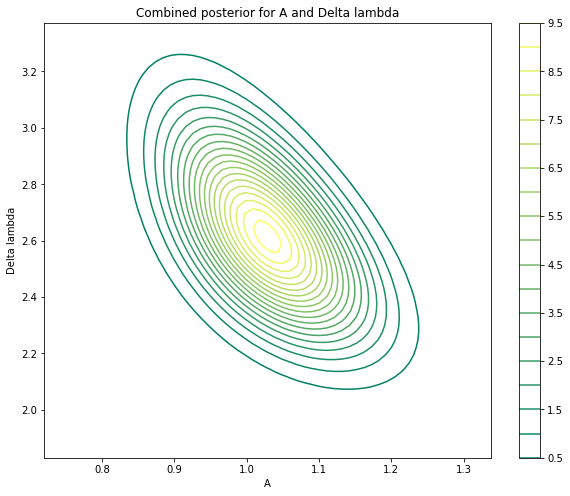

In [5]:
dl = maxlike.x[2]/steps 
dl_arr = np.arange(0.7*maxlike.x[2],1.3*maxlike.x[2],dl)

likelihood_A_dl=np.empty([len(dl_arr),len(A_arr)])
for i in range(len(dl_arr)):
    for j in range(len(A_arr)):
        likelihood_A_dl[i][j] = np.exp(-negloglike([A_arr[j],maxlike.x[1],dl_arr[i],maxlike.x[3]]))
posterior_A_dl = likelihood_A_dl/(np.sum(likelihood_A_dl)*dA*dl)

X,Y=np.meshgrid(A_arr,dl_arr)
plt.figure(figsize=(10,8))
plt.contour(X,Y,posterior_A_dl,20,cmap='summer')
plt.title('Combined posterior for A and Delta lambda')
plt.colorbar()
plt.xlabel('A')
plt.ylabel('Delta lambda')
plt.show()

6) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior marginalizes over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

Draw the contours to enclose 68%, 95% and 99% of the posterior.  To find the proper contour levels copy the function that is in the notes at the end of chapter 5.

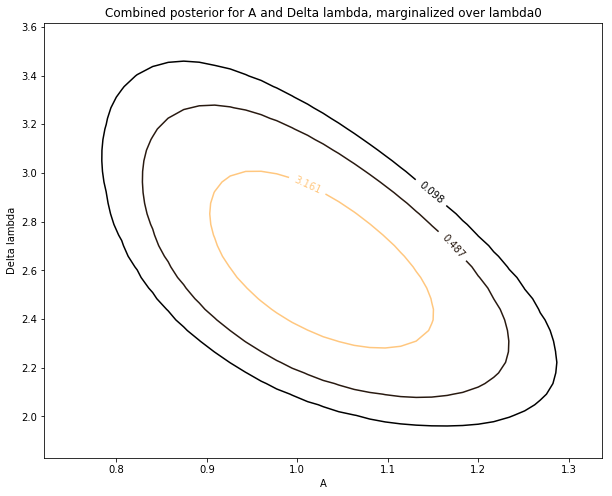

The yellow contour contains the 68% of the posterior, the brown one contains 95% and the black one 99%


In [6]:
#from now on I decided to assing the variable names using this method (in order to reduce as much as possibile the
#confusion): at the end of the name of the variable there is an underscore followed by a number; this number indicates
#the point of this tutorial where the variable was originally defined. This method is of course applied only to 
#variables that could generate ambiguity. 

import scipy.integrate as integ

steps2=60. #in order to have a faster compilation a lower number can be assigned to this variable
dA_6 = maxlike.x[0]/steps2
A_arr_6 = np.arange(0.7*maxlike.x[0],1.3*maxlike.x[0],dA_6)
dl_6 = maxlike.x[2]/steps2 
dl_arr_6 = np.arange(0.7*maxlike.x[2],1.4*maxlike.x[2],dl_6)

def posterior_fun(l0,A,dl,b):
    return np.exp(-negloglike(np.array([A,l0,dl,b])))

def marg_post(A,dl):
    return integ.quad(posterior_fun,0.7*maxlike.x[1],1.3*maxlike.x[1], args=(A,dl,maxlike.x[3]))[0]

marg_post_arr=np.empty([len(A_arr_6),len(dl_arr_6)])
for i in range(len(A_arr_6)):
    for j in range(len(dl_arr_6)):
        marg_post_arr[i][j]=marg_post(A_arr_6[i],dl_arr_6[j])
marg_post_arr=marg_post_arr/(np.sum(marg_post_arr)*dA_6*dl_6)


def find_level(posterior,fraction) :
    tot = np.sum(posterior)
    max = np.max(posterior)
    min = np.min(posterior)
    ## initialize level to halfway between max and min
    level = 0.5*(max + min)
    ## initialize fraction for this level
    frac = np.sum( posterior[ posterior >= level ] )/tot
    ## initialize resolution = +/- smallest pixel as fraction of total
    res = np.min( posterior[ posterior >= level ] )/tot
    ## iterate until frac is within res of the input fraction
    while( abs(frac - fraction) > res ) :
        ## update max or min
        if( frac > fraction) :
            min = level
        else :
            max = level
        ## update level by bisecting
        level = 0.5*(max + min)
        ## update frac and res
        frac = np.sum( posterior[ posterior >= level ] )/tot
        res = np.min( posterior[ posterior >= level ] )/tot
        ## output the level and its actual fraction
    return level,frac

contour_level_1,real_fraction_1 = find_level(marg_post_arr,0.68)
contour_level_2,real_fraction_2 = find_level(marg_post_arr,0.95)
contour_level_3,real_fraction_3 = find_level(marg_post_arr,0.99)

plt.figure(figsize=(10,8))
Y2,X2=np.meshgrid(dl_arr_6,A_arr_6)
CS=plt.contour(X2,Y2,marg_post_arr,levels=[contour_level_3,contour_level_2,contour_level_1],cmap='copper')
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Combined posterior for A and Delta lambda, marginalized over lambda0')
#plt.colorbar()
plt.xlabel('A')
plt.ylabel('Delta lambda')
plt.show()

print('The yellow contour contains the 68% of the posterior, the brown one contains 95% and the black one 99%')


7) Sum the 2D array from 6) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.

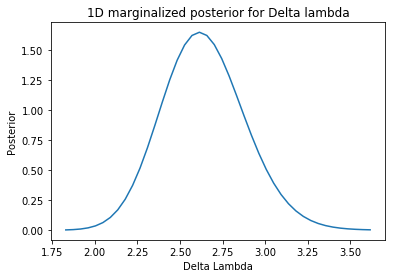

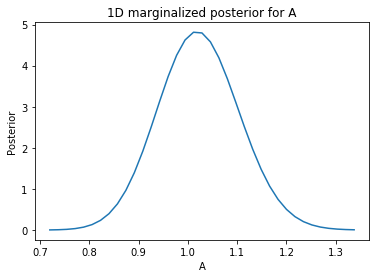

In [7]:
#print(marg_post_arr.shape)
marg_post_dl=np.empty(len(dl_arr_6))
for i in range(len(dl_arr_6)):
    marg_post_dl[i]=sum(marg_post_arr[:,i])
marg_post_dl=marg_post_dl/(np.sum(marg_post_dl)*dl_6)
#print(marg_post_dl)
plt.plot(dl_arr_6,marg_post_dl)
plt.xlabel('Delta Lambda')
plt.ylabel('Posterior')
plt.title('1D marginalized posterior for Delta lambda')
plt.show()

#print(marg_post_arr.shape)
marg_post_A=np.empty(len(A_arr_6))
for i in range(len(A_arr_6)):
    marg_post_A[i]=sum(marg_post_arr[i,:])
marg_post_A=marg_post_A/(sum(marg_post_A)*dA_6)
#print(marg_post_A)
#print (marg_post_A.shape)
plt.plot(A_arr_6,marg_post_A)
plt.xlabel('A')
plt.ylabel('Posterior')
plt.title('1D marginalized posterior for A')
plt.show()

8) Do the same as 6) and 7) but for $A$ and $\lambda_o$ and marginalized over $\Delta\lambda$.

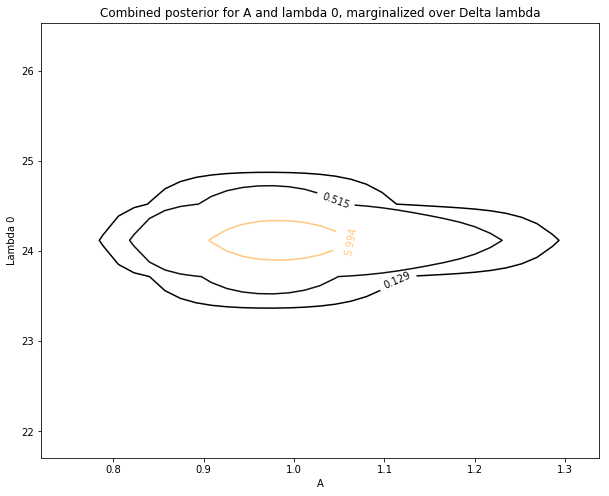

The yellow contour contains the 68% of the posterior, the brown one contains 95% and the black one 99%


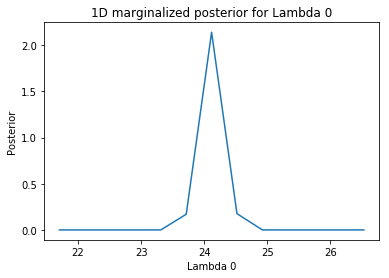

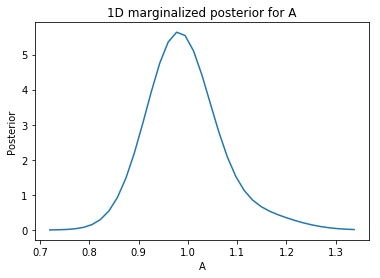

In [8]:
#In this point and in the following one (point 9) I decided to create new arrays for the variables (such as dA_8 and 
#A_arr_8) in order to have the possiblity to modify their limits without touching the ones in the previous point (such
#as dA_6 and A_arr_6)



dl0_8 = maxlike.x[1]/steps2 
l0_arr_8 = np.arange(0.9*maxlike.x[1],1.1*maxlike.x[1],dl0_8)
dA_8 = maxlike.x[0]/steps2 
A_arr_8 = np.arange(0.7*maxlike.x[0],1.3*maxlike.x[0],dA_8)

def posterior_fun_8(dl,A,l0,b):
    return np.exp(-negloglike(np.array([A,l0,dl,b])))

def marg_post_8(A,l0):
    return integ.quad(posterior_fun_8,-5*maxlike.x[2],5*maxlike.x[2], args=(A,l0,maxlike.x[3]))[0]

marg_post_arr_8=np.empty([len(A_arr_8),len(l0_arr_8)])
for i in range(len(A_arr_8)):
    for j in range(len(l0_arr_8)):
        marg_post_arr_8[i][j]=marg_post_8(A_arr_8[i],l0_arr_8[j])
marg_post_arr_8=marg_post_arr_8/(np.sum(marg_post_arr_8)*dA_8*dl0_8)

contour_level_8_1,real_fraction_8_1 = find_level(marg_post_arr_8,0.68)
contour_level_8_2,real_fraction_8_2 = find_level(marg_post_arr_8,0.95)
contour_level_8_3,real_fraction_8_3 = find_level(marg_post_arr_8,0.99)

plt.figure(figsize=(10,8))
Y3,X3=np.meshgrid(l0_arr_8,A_arr_8)
CS_1=plt.contour(X3,Y3,marg_post_arr_8,levels=[contour_level_8_3,contour_level_8_2,contour_level_8_1],cmap='copper')
plt.clabel(CS_1, inline=1, fontsize=10)
plt.title('Combined posterior for A and lambda 0, marginalized over Delta lambda')
#plt.colorbar()
plt.xlabel('A')
plt.ylabel('Lambda 0')
plt.show()

print('The yellow contour contains the 68% of the posterior, the brown one contains 95% and the black one 99%')


marg_post_l0=np.empty(len(l0_arr_8))
for i in range(len(l0_arr_8)):
    marg_post_l0[i]=sum(marg_post_arr_8[:,i])
marg_post_l0=marg_post_l0/(sum(marg_post_l0)*dl0_8)
plt.plot(l0_arr_8,marg_post_l0)
plt.xlabel('Lambda 0')
plt.ylabel('Posterior')
plt.title('1D marginalized posterior for Lambda 0')
plt.show()

marg_post_A_8=np.empty(len(A_arr_8))
for i in range(len(A_arr_8)):
    marg_post_A_8[i]=sum(marg_post_arr_8[i,:])
marg_post_A_8=marg_post_A_8/(sum(marg_post_A_8)*dA_8)
plt.plot(A_arr_8,marg_post_A_8)
plt.xlabel('A')
plt.ylabel('Posterior')
plt.title('1D marginalized posterior for A')
plt.show()

9) Do the same as 6) and 7) but for $\Delta\lambda$ and $\lambda_o$ and marginalized over $A$.

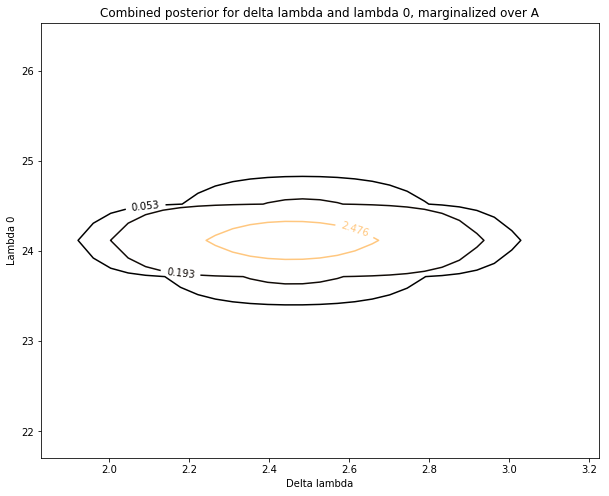

The yellow contour contains the 68% of the posterior, the brown one contains 95% and the black one 99%


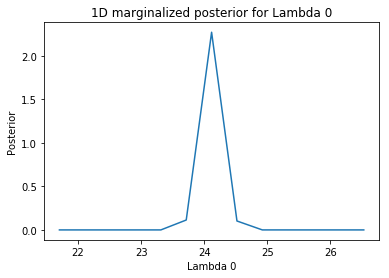

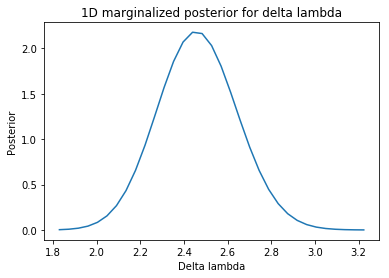

In [9]:
dl0_9 = maxlike.x[1]/steps2 
l0_arr_9 = np.arange(0.9*maxlike.x[1],1.1*maxlike.x[1],dl0_9)
dl_9 = maxlike.x[2]/steps2 
dl_arr_9 = np.arange(0.7*maxlike.x[2],1.25*maxlike.x[2],dl_9)

def posterior_fun_9(A,l0,dl,b):
    return np.exp(-negloglike(np.array([A,l0,dl,b])))

def marg_post_9(l0,dl):
    return integ.quad(posterior_fun_9,-10*maxlike.x[0],10*maxlike.x[0], args=(l0,dl,maxlike.x[3]))[0]

marg_post_arr_9=np.empty([len(l0_arr_9),len(dl_arr_9)])
for i in range(len(l0_arr_9)):
    for j in range(len(dl_arr_9)):
        marg_post_arr_9[i][j]=marg_post_9(l0_arr_9[i],dl_arr_9[j])
marg_post_arr_9=marg_post_arr_9/(np.sum(marg_post_arr_9)*dl_9*dl0_9)

contour_level_9_1,real_fraction_9_1 = find_level(marg_post_arr_9,0.68)
contour_level_9_2,real_fraction_9_2 = find_level(marg_post_arr_9,0.95)
contour_level_9_3,real_fraction_9_3 = find_level(marg_post_arr_9,0.99)

plt.figure(figsize=(10,8))
X4,Y4=np.meshgrid(dl_arr_9,l0_arr_9)
CS_2=plt.contour(X4,Y4,marg_post_arr_9,levels=[contour_level_9_3,contour_level_9_2,contour_level_9_1],cmap='copper')
plt.clabel(CS_2, inline=1, fontsize=10)
plt.title('Combined posterior for delta lambda and lambda 0, marginalized over A')
#plt.colorbar()
plt.xlabel('Delta lambda')
plt.ylabel('Lambda 0')
plt.show()

print('The yellow contour contains the 68% of the posterior, the brown one contains 95% and the black one 99%')


marg_post_l0_9=np.empty(len(l0_arr_9))
for i in range(len(l0_arr_9)):
    marg_post_l0_9[i]=sum(marg_post_arr_9[i,:])
marg_post_l0_9=marg_post_l0_9/(sum(marg_post_l0_9)*dl0_9)
plt.plot(l0_arr_9,marg_post_l0_9)
plt.xlabel('Lambda 0')
plt.ylabel('Posterior')
plt.title('1D marginalized posterior for Lambda 0')
plt.show()

marg_post_dl_9=np.empty(len(dl_arr_9))
for i in range(len(dl_arr_9)):
    marg_post_dl_9[i]=sum(marg_post_arr_9[:,i])
marg_post_dl_9=marg_post_dl_9/(sum(marg_post_dl_9)*dl_9)
plt.plot(dl_arr_9,marg_post_dl_9)
plt.xlabel('Delta lambda')
plt.ylabel('Posterior')
plt.title('1D marginalized posterior for delta lambda')
plt.show()

10) Give the maximum likelihood estimate of each of the three parameters and 
their marginalized standard deviation. 

In [10]:
#For all of the three variables we have two marginalized and summed 1D posterior, their shapes look like gaussian, so 
#someone can fit it and then calculate the mean and the average value. I decided to use the posterior and the variables 
#as an numpy arrays and to calculate their weighted (where the posterior is the weight) mean and their standard 
#deviation using numpy or classic methods and functions.

#The decision not to fit the posteriors with gaussians distribution was made because some of them show a non simmetric
#shape, and so the fit parameters would have not represent the data correctly.

Aave=np.sum(marg_post_A*A_arr_6)/sum(marg_post_A)
Astd=np.sqrt(np.sum((A_arr_6-Aave)**2)/len(A_arr_6))
print('The average of the posterior for A, marginalized over lambda 0 and summed over delta lambda is '+ str(Aave))
print('In this case the standard deviation for A is '+str(Astd))
Aave_2= np.sum(marg_post_A_8*A_arr_8)/(sum(marg_post_A_8))
Astd_2=np.sqrt(np.sum((A_arr_6-Aave_2)**2)/len(A_arr_8))
print('The average of the posterior for A, marginalized over Delta lambda and summed over Lambda 0 is '+ str(Aave_2))
print('In this case the standard deviation for A is '+str(Astd_2))
print()

dlave=np.sum(marg_post_dl*dl_arr_6)/sum(marg_post_dl)
dlstd=np.sqrt(np.sum((dl_arr_6-dlave)**2)/len(dl_arr_6))
print('The average of the posterior for delta lambda, marginalized over lambda 0 and summed over A is '+ str(dlave))
print('In this case the standard deviation for delta lambda is '+str(dlstd))
dlave_2= np.sum(marg_post_dl_9*dl_arr_9)/(sum(marg_post_dl_9))
dlstd_2=np.sqrt(np.sum((dl_arr_9-dlave_2)**2)/len(dl_arr_9))
print('The average of the posterior for delta lambda, marginalized over A and summed over lambda 0 is '+ str(dlave_2))
print('In this case the standard deviation for delta lambda is '+str(dlstd_2))
print()

l0ave=np.sum(marg_post_l0*l0_arr_8)/sum(marg_post_l0)
l0std=np.sqrt(np.sum((l0_arr_8-l0ave)**2)/len(l0_arr_8))
print('The average of the posterior for lambda zero, marginalized over delta lambda and summed over A is '+ str(l0ave))
print('In this case the standard deviation for lambda 0 is '+str(l0std))
l0ave_2= np.sum(marg_post_l0_9*l0_arr_9)/(sum(marg_post_l0_9))
l0std_2=np.sqrt(np.sum((l0_arr_9-l0ave_2)**2)/len(l0_arr_9))
print('The average of the posterior for lambda 0, marginalized over A and summed over delta lambda is '+ str(l0ave_2))
print('In this case the standard deviation for lambda 0 is '+str(l0std_2))


The average of the posterior for A, marginalized over lambda 0 and summed over delta lambda is 1.0223164682117123
In this case the standard deviation for A is 0.1831629069687123
The average of the posterior for A, marginalized over Delta lambda and summed over Lambda 0 is 0.9941850622929018
In this case the standard deviation for A is 0.1862722859964766

The average of the posterior for delta lambda, marginalized over lambda 0 and summed over A is 2.640242150132718
In this case the standard deviation for delta lambda is 0.5344938766190881
The average of the posterior for delta lambda, marginalized over A and summed over lambda 0 is 2.462855181628493
In this case the standard deviation for delta lambda is 0.4197415491660569

The average of the posterior for lambda zero, marginalized over delta lambda and summed over A is 24.118186783293446
In this case the standard deviation for lambda 0 is 1.5039700426225695
The average of the posterior for lambda 0, marginalized over A and summed over

11) Calculate the evidence for the data without the line.  Take $\lambda_o$ and $\Delta\lambda$ to be fixed to their bast fit values.  Calculate the evidence for the data with the line using a uniform prior for $A$ between 0 and 1.  What is the odds for there being an emission line?

In [32]:
evidence_back=sum(posterior*background)
print('The evidence for the data without the line is '+str(evidence_back))

#in point number 4 of this tutorial we calculated the posterior for A taking lambda 0 and delta lambda to be fixed to 
#their best fit values. 

evidence_A=sum(posterior_A*A_arr)
print('The evidence for the data with the line is '+str(evidence_A))

print('The odds for there being an emission line is '+str(evidence_A/evidence_back))


The evidence for the data without the line is 54.53108678141709
The evidence for the data with the line is 99.9999996360461
The odds for there being an emission line is 1.8338163704106434
